In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats.mstats import winsorize

In [42]:
df_train = pd.read_csv('/kaggle/input/ml-olympiad-for-students-topvistos-eua/train.csv')
df_test = pd.read_csv('/kaggle/input/ml-olympiad-for-students-topvistos-eua/test.csv')
df_test.head()

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral
0,EZYV22339,Ásia,Ensino Superior,S,N,2414,1973,Nordeste,103320.80,Ano,N
1,EZYV9333,Ásia,Mestrado,N,S,2928,1937,Oeste,49786.35,Ano,S
2,EZYV9740,Ásia,Ensino Superior,S,N,1836,1999,Oeste,60855.83,Ano,S
3,EZYV3328,Ásia,Ensino Superior,S,N,122,2004,Sul,82379.06,Semana,S
4,EZYV12321,América do Sul,Ensino Superior,S,S,1720,2003,Nordeste,6719.81,Ano,S


In [34]:
df_train.duplicated().sum()

0

In [35]:
df_train['status_do_caso'].value_counts()

Aprovado    11937
Negado       5899
Name: status_do_caso, dtype: int64

# Feature transformations

In [43]:
# Set binary features
binary_features = ['tem_experiencia_de_trabalho', 'requer_treinamento_de_trabalho', 'posicao_em_tempo_integral']
for feat in binary_features:
    df_train[feat] = df_train[feat].map({'N': 0, 'S': 1})
    df_test[feat] = df_test[feat].map({'N': 0, 'S': 1})

df_train['status_do_caso'] = df_train['status_do_caso'].map({'Negado':0, 'Aprovado':1})


# Ordinal feature: set numbers
df_train['educacao_do_empregado'] = df_train['educacao_do_empregado'].map({'Ensino Médio': 0,'Ensino Superior': 1, \
                                                                      'Mestrado': 2, 'Doutorado': 3})
df_test['educacao_do_empregado'] = df_test['educacao_do_empregado'].map({'Ensino Médio': 0,'Ensino Superior': 1, \
                                                                      'Mestrado': 2, 'Doutorado': 3})


# Nominal features : one-hot encoding
dummies_cols = ['continente', 'regiao_de_emprego', 'unidade_de_salario']
for col in dummies_cols:
    df_train[col+'_original'] = df_train[col]
    df_test[col+'_original'] = df_test[col]
    df_train = pd.get_dummies(df_train, columns=[col], drop_first=True, prefix=col, prefix_sep='_')
    df_test = pd.get_dummies(df_test, columns=[col], drop_first=True, prefix=col, prefix_sep='_')


#  Set company age
df_train['ano_de_estabelecimento'] = 2023 - df_train['ano_de_estabelecimento']
df_test['ano_de_estabelecimento'] = 2023 - df_test['ano_de_estabelecimento'] 


# Set feature types
num_cols = ['num_de_empregados', 'ano_de_estabelecimento', 'salario_prevalecente']
cat_cols = [col for col in df_train.columns if col not in num_cols]
test_cat_cols = [col for col in cat_cols if col != 'status_do_caso']

df_train[num_cols] = df_train[num_cols].astype(float)
df_test[num_cols] = df_test[num_cols].astype(float)
df_train[cat_cols] = df_train[cat_cols].astype('category')
df_test[test_cat_cols] = df_test[test_cat_cols].astype('category')

df_test.head()

,id_do_caso,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,salario_prevalecente,posicao_em_tempo_integral,continente_original,continente_América do Sul,...,continente_Ásia,regiao_de_emprego_original,regiao_de_emprego_Meio-Oeste,regiao_de_emprego_Nordeste,regiao_de_emprego_Oeste,regiao_de_emprego_Sul,unidade_de_salario_original,unidade_de_salario_Hora,unidade_de_salario_Mês,unidade_de_salario_Semana
0,EZYV22339,1,1,0,2414.0,50.0,103320.80,0,Ásia,0,...,1,Nordeste,0,1,0,0,Ano,0,0,0
1,EZYV9333,2,0,1,2928.0,86.0,49786.35,1,Ásia,0,...,1,Oeste,0,0,1,0,Ano,0,0,0
2,EZYV9740,1,1,0,1836.0,24.0,60855.83,1,Ásia,0,...,1,Oeste,0,0,1,0,Ano,0,0,0
3,EZYV3328,1,1,0,122.0,19.0,82379.06,1,Ásia,0,...,1,Sul,0,0,0,1,Semana,0,0,1
4,EZYV12321,1,1,1,1720.0,20.0,6719.81,1,América do Sul,1,...,0,Nordeste,0,1,0,0,Ano,0,0,0


# EDA

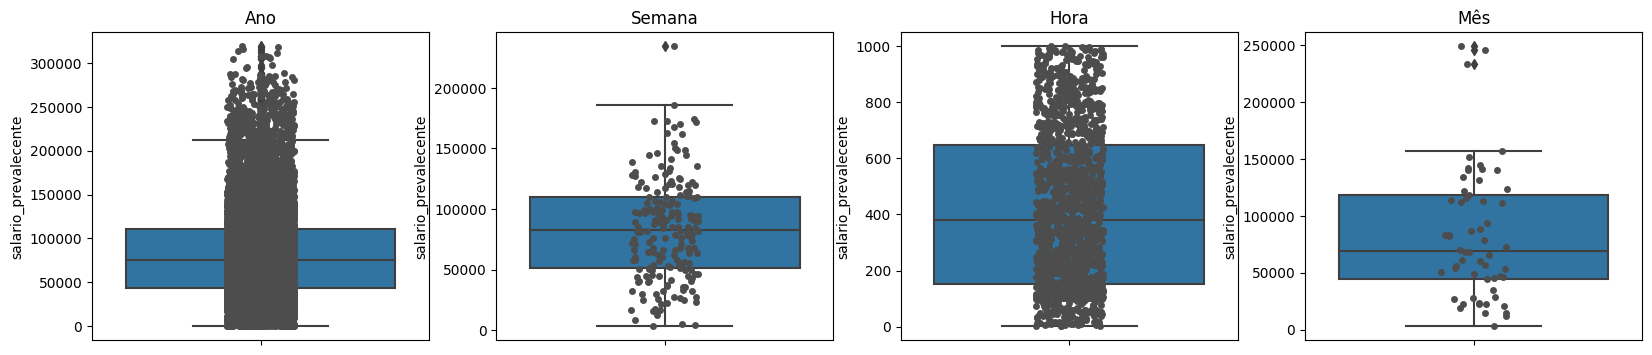

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
unidades_unique = df_train['unidade_de_salario_original'].unique()
for i,unidade in enumerate(unidades_unique):
    filtered = df_train[df_train['unidade_de_salario_original'] == unidade]
    plt.subplot(1,4,i+1)
    plt.title(unidade)
    sns.boxplot(y='salario_prevalecente', data=filtered)
    sns.stripplot(y='salario_prevalecente', data=filtered, color=".3")
    

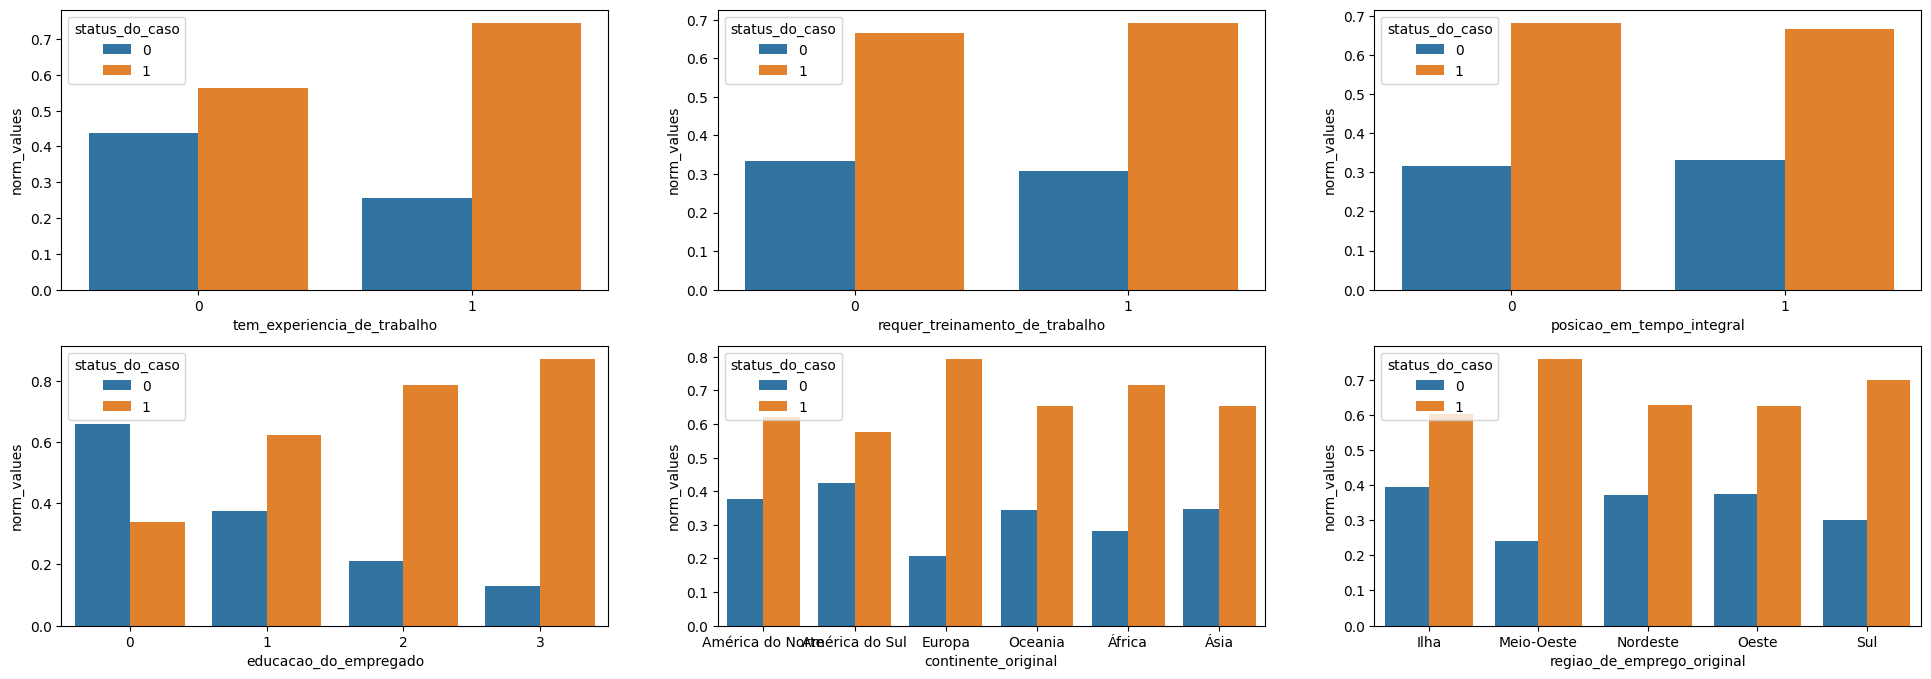

In [39]:
cat_features = ['tem_experiencia_de_trabalho','requer_treinamento_de_trabalho', 'posicao_em_tempo_integral', \
              'educacao_do_empregado', 'continente_original', 'regiao_de_emprego_original']
ax, fig = plt.subplots(2,3,figsize=(24,8))
for i,feat in enumerate(cat_features):
    plt.subplot(2,3,i+1)
    teste = df_train.groupby(feat)['status_do_caso'].value_counts(normalize=True)
    teste = teste.to_frame().rename(columns={'status_do_caso': 'norm_values'}).reset_index()
    sns.barplot(data=teste, x=feat, y='norm_values', hue='status_do_caso')
    


Ter experiência de trabalho e a educação do empregado parece ter diferença significativa na aprovação do certificado, o continente e a região do emprego também possui diferença, e requer treinamento ou a posição integral não parecem influenciar muito.

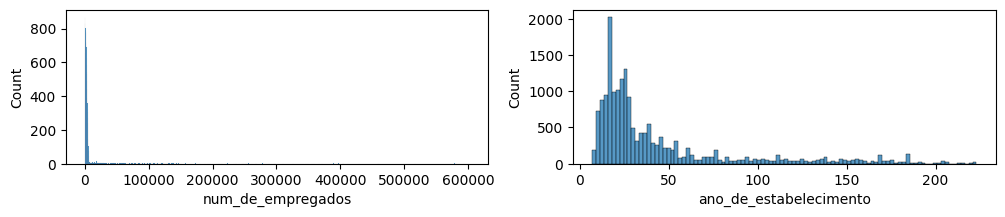

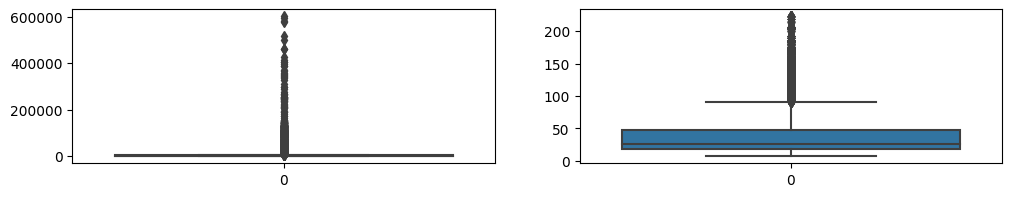

In [9]:
hist_cols = ['num_de_empregados', 'ano_de_estabelecimento']

fig, ax = plt.subplots(1,2,figsize=(12,2))
for i,col in enumerate(hist_cols):
    plt.subplot(1,2,i+1)
    sns.histplot(df_train[col])
    
fig, ax = plt.subplots(1,2,figsize=(12,2))
for i,col in enumerate(hist_cols):
    plt.subplot(1,2,i+1)
    sns.boxplot(df_train[col])

# Outliers

In [44]:
df_train['ano_de_estabelecimento'] = winsorize(df_train['ano_de_estabelecimento'],(0, 0.15))
df_train['num_de_empregados'] = winsorize(df_train['num_de_empregados'],(0.05, 0.1))

## Mutual Information

In [45]:
# Calcula Mutual Information para verificar relação das features com o target

# Drop string columns used for EDA
original_cols = [col for col in df_train.columns if col[-8:] == 'original']
df_train = df_train.drop(original_cols, axis=1)
df_test = df_test.drop(original_cols, axis=1)

# Set X and y
X = df_train.drop(['status_do_caso', 'id_do_caso'], axis=1)
discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
y = df_train['status_do_caso']
x_test = df_test.drop('id_do_caso', axis=1)

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores

educacao_do_empregado             0.054474
tem_experiencia_de_trabalho       0.019908
requer_treinamento_de_trabalho    0.001276
num_de_empregados                 0.001709
ano_de_estabelecimento            0.000000
salario_prevalecente              0.019885
posicao_em_tempo_integral         0.004805
continente_América do Sul         0.004630
continente_Europa                 0.010318
continente_Oceania                0.004184
continente_África                 0.000479
continente_Ásia                   0.000000
regiao_de_emprego_Meio-Oeste      0.002506
regiao_de_emprego_Nordeste        0.000000
regiao_de_emprego_Oeste           0.001338
regiao_de_emprego_Sul             0.003715
unidade_de_salario_Hora           0.013107
unidade_de_salario_Mês            0.000000
unidade_de_salario_Semana         0.002581
Name: MI Scores, dtype: float64

# Feature Selection

In [46]:
# Based on mutual informarion scores
k = 12
selected_cols = mi_scores.sort_values(ascending=False)[:k].index.to_list()
selected_cols

X = X[selected_cols]
x_test = x_test[selected_cols]

# Modeling

In [47]:
x_train, x_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True, \
                                                  random_state=42, test_size=0.2)
print(x_train.shape)
print(x_val.shape)

(14268, 12)
(3568, 12)


In [184]:
model_rf = RandomForestClassifier()
model_gb = GradientBoostingClassifier()

cv = StratifiedKFold(n_splits=5)

params_rf = {
    'max_depth': [3, 5, 7],
    'n_estimators':[50, 100, 200],
    'min_samples_leaf': [10, 20]
}

params_gb = {
    'n_estimators' : [50, 100, 200],
    'learning_rate' : [0.01, 0.1, 0.2],
    'min_samples_leaf' : [10, 20],
    'max_depth' : [3, 5, 7]
}

model_cv = GridSearchCV(model_gb, param_grid=params_gb, scoring='f1_macro', refit=True, cv=cv, verbose=3)
model_cv.fit(x_train,y_train)
model_cv.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=50;, score=0.401 total time=   0.7s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=50;, score=0.401 total time=   0.7s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=50;, score=0.401 total time=   0.7s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=50;, score=0.401 total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=50;, score=0.401 total time=   0.7s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=100;, score=0.624 total time=   1.3s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=100;, score=0.632 total time=   1.3s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=100;, score=0.635 total time=   1.3s
[CV 4/5

0.6960933199390398

In [185]:
best_params = model_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 10,
 'n_estimators': 50}

In [186]:
y_pred = model_cv.best_estimator_.predict(x_val)
print(f1_score(y_val, y_pred, average='macro'))
print(precision_score(y_val, y_pred, average='macro'))

0.7169437472156637
0.7411997531679891


In [199]:
y_pred_proba = model_cv.best_estimator_.predict_proba(x_val)

# Decision threshold
d_th = 0.6
y_pred = []
for proba in y_pred_proba:
    if proba[1] > d_th:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_pred = np.array(y_pred)

print(f1_score(y_val, y_pred, average='macro'))
print(precision_score(y_val, y_pred, average='macro'))


0.7245291978012618
0.7302203860428603


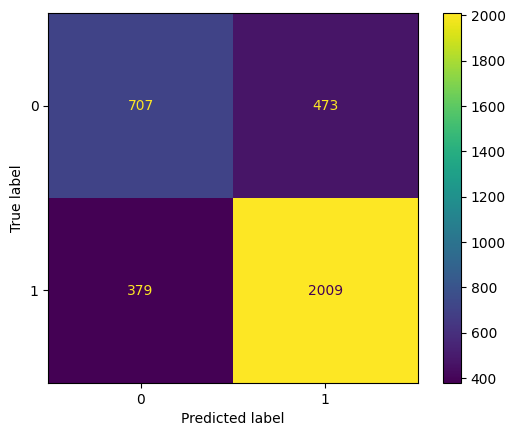

In [200]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)